# AT3 - Airfare dataset modelling for prediction - XGBoost

## 1. Loading the datasets

In [1]:
# 1.1. Launch commands to automatically reload modules
%load_ext autoreload
%autoreload 2

In [2]:
# 1.2. Import the packages and custom functions
import pandas as pd
import numpy as np
import sys
import os

# Get the current working directory
current_dir = os.getcwd()

# Add the src directory to sys.path
sys.path.append(os.path.abspath(os.path.join(current_dir, '..', 'src')))

from models.sets import load_sets
from models.performance import plot_regressor_scores
from models.null import NullRegressor
from models.data_exploration import display_data_info

In [3]:
# 1.3. Load the datasets
X_train, y_train, X_val, y_val, X_test, y_test = load_sets()

In [4]:
# Print the column names of X_train
print(X_train.columns.tolist())

['startingAirport', 'destinationAirport', 'departure_dayofweek', 'departure_month', 'departure_hour', 'departure_minute', 'cabin_type']


## 2. Data transformation and Modelling

## 2.1 Pipelines for transformations

In [5]:
# Import packages
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer


from models.sets import cyclical_transform

In [6]:
# Specify the columns for cyclical features
cyclical_cols = ['departure_month', 'departure_hour', 'departure_minute']

# Specify categorical columns
cat_cols = ['startingAirport', 'destinationAirport', 'departure_dayofweek', 'cabin_type']

In [7]:
# Define the categorical transformer
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Define the cyclical transformer
cyclical_transformer = Pipeline(steps=[
    ('cyclical', FunctionTransformer(cyclical_transform, validate=False))
])

In [8]:
# Define which columns to apply each transformer to
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, cat_cols),
        ('cyclical', cyclical_transformer, cyclical_cols)
    ],
    remainder='drop' 
)

## 2.2 Modelling and evaluation

## 2.2.1 Experiment C1: Modelling

In [9]:
# Create a Pipeline called xgb_pipe that contains the preprocessor and an XGBoost regressor
xgb_pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('xgb', XGBRegressor(
            objective='reg:squarederror',  # Specify the objective function
            random_state=42
        ))
    ]
)

In [10]:
# Fit sgd_pipe with training dataset
xgb_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['startingAirport',
                                                   'destinationAirport',
                                                   'departure_dayofweek',
                                                   'cabin_type']),
                                                 ('cyclical',
                                                  Pipeline(steps=[('cyclical',
                                                                   FunctionTransformer(func=<function cyclical_transform at 0x0000012B49134C20>))]),
                                                  ['departure_mont...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

## 2.2.2 Experiment C1: Model Evaluation

In [11]:
# Make predictions on training dataset and store the predictions in train_preds
train_preds = xgb_pipe.predict(X_train)

RMSE Training: 143.13
MAE Training: 100.52


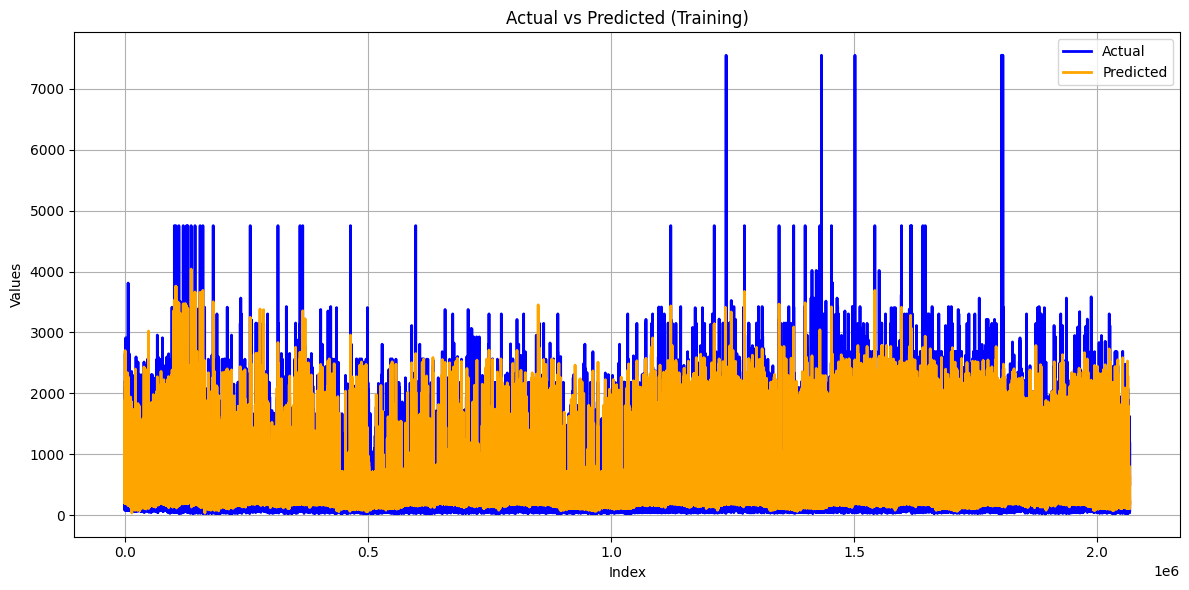

In [12]:
# Training data: Display the RMSE and MAE scores and plot the prediction of sgd model
plot_regressor_scores(y_preds=train_preds, y_actuals=y_train, set_name='Training')

RMSE Validation: 157.87
MAE Validation: 108.36


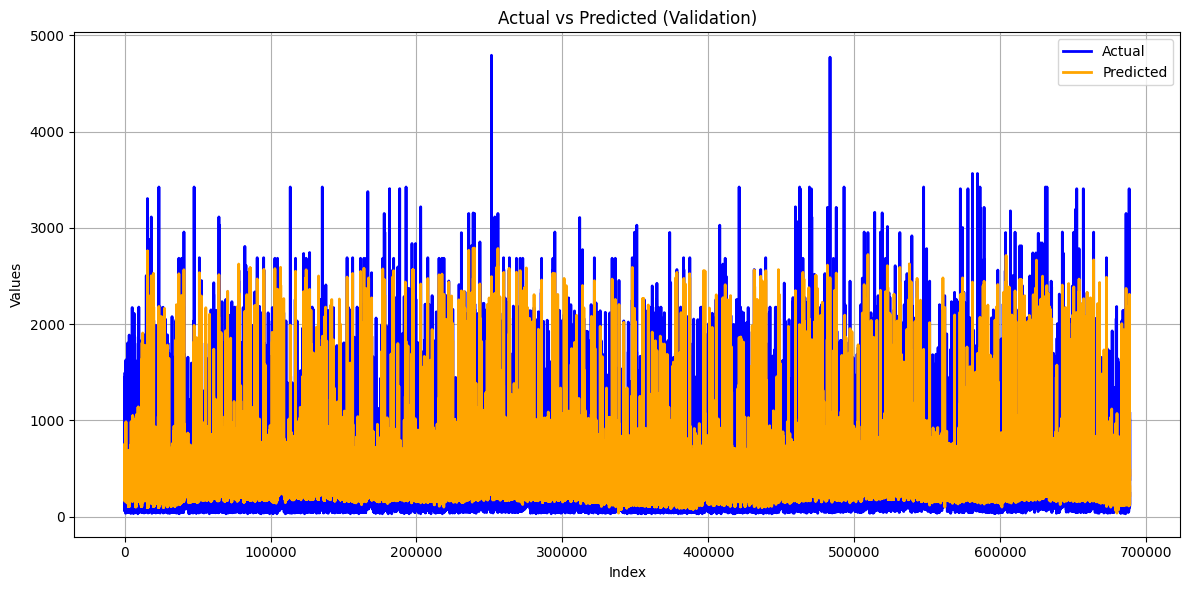

In [13]:
# Validation data: Display the RMSE and MAE scores and plot the prediction of sgd model
val_preds = xgb_pipe.predict(X_val)
plot_regressor_scores(y_preds=val_preds, y_actuals=y_val, set_name='Validation')

RMSE Test: 164.58
MAE Test: 117.87


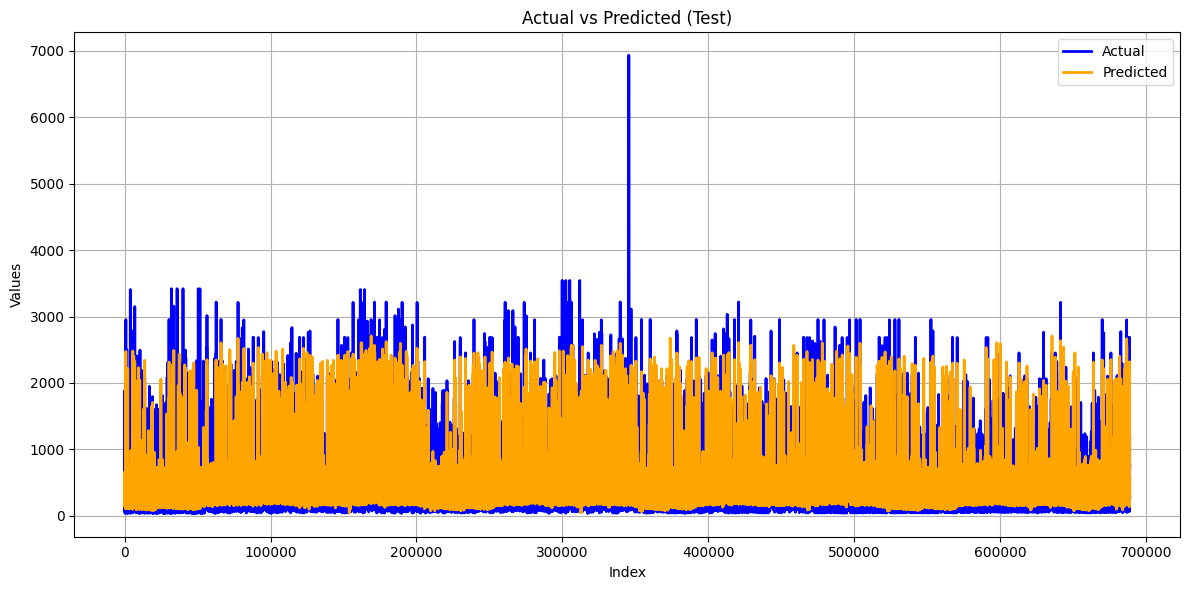

In [14]:
# Test data: Display the RMSE and MAE scores and plot the prediction of sgd model
test_preds = xgb_pipe.predict(X_test)
plot_regressor_scores(y_preds=test_preds, y_actuals=y_test, set_name='Test')

In [15]:
# Save the model 
# Import dump from joblib package and save into models folder
from joblib import dump

dump(xgb_pipe,  '../models/pine_xgb_pipeline_final.joblib')

['../models/pine_xgb_pipeline_final.joblib']